#### Setup
We first set the notebook to display the output from each code block, <br>
then import the required packages and set the file directory.

In [1]:
from __future__ import print_function
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.colors
import numpy as np
import pandas as pd
import rasterio
import os


try:
    import keras
    from keras.models import model_from_json
    from keras.optimizers import Adam
    from keras.losses import categorical_crossentropy
    import tensorflow as tf

except:
    print("Keras not found")
    
np.random.seed(42)

def my_basename(path):
    return os.path.splitext(os.path.split(path)[1])[0]

file_dir=r'/Users/neeraj/BTP'

cycler
dateutil
kiwisolver
numpy
pyparsing
certifi
numexpr
bottleneck
setuptools._distutils
distutils
setuptools._distutils
_distutils_system_mod
distutils.core
setuptools.msvc


2023-05-10 05:09:20.764815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


google._upb._message
tensorflow.python.data.ops.batch_op
tensorflow.python.data.ops.prefetch_op
tensorflow.python.data.ops.shuffle_op
tensorflow.python.data.ops.repeat_op
tensorflow.compiler.tf2tensorrt.ops.gen_trt_ops
tensorflow.compiler.tf2tensorrt._pywrap_py_utils
keras.api._v2.keras


#### Prepare global predictions 
To be able to predict global distributions, we must first load in the stacked world raster map and the species we want to make the predictions for. <br>
Next to this, a colormap needs to be made for the range of predicted probability of presence in each cell.

In [2]:
##opening raster as 3d numpy array
# inRas=gdal.Open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')
# myarray=inRas.ReadAsArray()
with rasterio.open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif') as src:
    # Read the raster data as a NumPy array
    myarray = src.read()

print(myarray.shape)
print(type(myarray))


(41, 1800, 4320)
<class 'numpy.ndarray'>


In [3]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/results/DNN_performance/DNN_eval.txt",sep="\t")
taxa=taxa["Species"]

zstandard


matplotlib_inline.backend_inline
matplotlib_inline.backend_inline


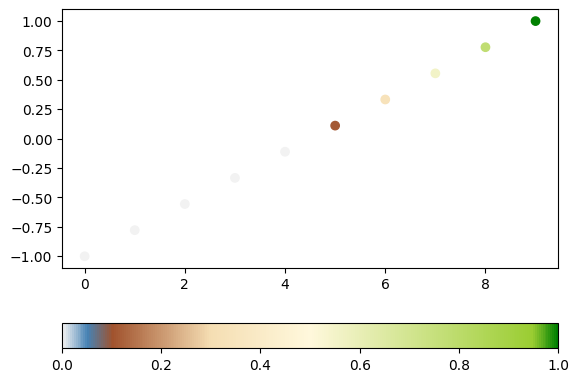

In [4]:
#create colormap for maps
norm = matplotlib.colors.Normalize(0,1)
colors = [[norm(0), "0.95"],
          [norm(0.05),"steelblue"],
          [norm(0.1),"sienna"],
          [norm(0.3),"wheat"],
          [norm(0.5),"cornsilk"],
          [norm(0.95),"yellowgreen"],
          [norm(1.0),"green"]]
        
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
custom_cmap.set_bad(color="white")

fig, ax=plt.subplots()
x = np.arange(10)
y = np.linspace(-1,1,10)
sc = ax.scatter(x,y, c=y, norm=norm, cmap=custom_cmap)
fig.colorbar(sc, orientation="horizontal")
plt.show()

The bands in the stacked raster map differ in the detail of continental outline, especially along the coastlines and for inland lakes. This creates problems when making global predictions as the model will always set them to 1. To combat this issue we take two input maps with high detail outlines of the continents and lakes (Aspect 5deg and ClayPercentage) and save the index values where these bands contain no-data values. These index values are masked from the global prediction that is made.

In [5]:
###create an index of the continental borders and coastal, lake cells that should be excluded from prediction
### Aspect and clay percentage raster have high resolution outline
src=rasterio.open(file_dir+'/data/GIS/5_deg/Aspect_5deg.tif')
b=src.read(1)
minb=np.min(b)
index_minb1=np.where(b==minb)

src=rasterio.open(file_dir+'/data/GIS/5_deg/ClayPercentage_5min.tif')
b=src.read(1)
minb=np.min(b)
index_minb2=np.where(b==minb)

#### Create global predictions
Going iteratively through the species, the DNN model network and weights are recostructed using .json and .h5 files. A numpy array containing the environmental variable values of all terrestrial cells is then opened and fed to the model. <br>

The predicted probabilities for output class 1 (present) are extracted and put into a numpy array. The values of this numpy array are subset into a copy of the first band of the stacked world raster.The inland lakes and coastlines are masked from the prediction using the index values extracted earlier and the profile of the copied band is updated to a single-band raster. <br>

This single band raster is saved as a Tiff file and used to make a colormap version that is easier to interpret and suitable for publication. 

In [6]:
%%capture
for species in taxa[:]:

    spec=species
    print("processing", spec)
    spec=spec.replace(" ","_")

    ##########################################################
    #  reconstruct the model and run the prediction globally #
    ##########################################################

    input_X=np.load(file_dir+'/data/GIS/world_prediction_array.npy')
    df=pd.DataFrame(input_X)

    #create copy of band to later subset values in
    new_band=myarray[1].copy()
    new_band.shape

    ### Load DNN model for the species and predict values:
    json_file = open(file_dir+'/results/{}/{}_model.json'.format(spec,spec),'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    #load weights into new model
    loaded_model.load_weights(file_dir+'/results/{}/{}_model.h5'.format(spec,spec))

    #compile model
    loaded_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

    #predict values for world map
    # print(type(input_X))
    new_values = loaded_model.predict(x=input_X,batch_size=500,verbose=0) ###predict output value

    ##take the prob. of presence (new_value.item((0,1))) and put into numpy array
    new_band_values=[]
    for i in new_values:
        new_value=i[1]
        new_band_values.append(new_value)
    new_band_values=np.array(new_band_values)

    df=pd.read_csv(file_dir+'/data/GIS/world_prediction_row_col.csv')
    row=df["row"]
    row=row.values
    col=df["col"]
    col=col.values
    
    #################################
    # subset output into rasterband #
    #################################
    for i in range(0,len(row)):
        new_band[int(row[i]),int(col[i])]=new_band_values[i]

    new_band[index_minb1]=np.nan #exclude lakes, inland seas, coastline
    new_band[index_minb2]=np.nan
    
    src=rasterio.open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')
    profile=src.profile
    profile.update(count=1)

    #write to file
    with rasterio.open(file_dir+'/results/{}/{}_predicted_map.tif'.format(spec,spec), 'w', **profile) as dst:
        dst.write(new_band, 1) 
        
    ####################################
    # create additional colormap image #
    ####################################
    
    clipped = rasterio.open(file_dir+'/results/{}/{}_predicted_map.tif'.format(spec,spec))
    
    array = clipped.read(1)
    array_data = clipped.read(1,masked=True)
    array_data[index_minb1]=np.nan
    array_data[index_minb2]=np.nan
    array_meta = clipped.profile
    
    #create figure
    my_dpi=96
    fig, ax = plt.subplots(figsize=(4320/my_dpi, 1800/my_dpi))
    im=ax.imshow(array_data,cmap=custom_cmap,interpolation="bilinear",vmin=0,vmax=0.99)#,filternorm=1)
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right",size="2%",pad=0.1)
    fig.colorbar(im,cax=cax)
    spec=spec.replace("_"," ")
    plt.yticks(fontsize=40)
    ax.set_title('%s prediction map'%spec,fontsize=80)
    
    #save to file
    spec=spec.replace(" ","_")
    plt.savefig(file_dir+'/results/{}/{}_predicted_map_color.png'.format(spec,spec),dpi=my_dpi)
    
    #next species!